# M7_AI3_Generación de texto
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad individual 4 propuesta en el Modulo **Técnicas Avanzadas de Machine Learning**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos.
#### Enero 11, 2025

# Generación de texto con una red LSTM
En esta actividad vamos a utilizar una red recurrente LSTM para generar texto.

El corpus que sirve de referencia para generar los textos consiste en Alicia en el País de las Maravillas, aunque se puede utilizar cualquier otro.

El interés de esta actividad es utilizar las redes **LSTM para algo distinto de una clasificación**, aunque, como se puede observar, la calidad de los textos generados es inferior a la que se consigue con otros modelos más actuales, como los transformer.

**Debes completar el código en las secciones indicadas con # COMPLETAR CODIGO**

## Instalación e importación de paquetes

In [1]:
!pip install progressbar2

In [2]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import html

import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
import pickle
import random
import progressbar
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

print(f"use_moses_detokenizer={use_moses_detokenizer}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


use_moses_detokenizer=False


## Definición de parámetros del corpus y su preprocesado

In [3]:
corpus_url = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
corpus_path = "alicia.txt"
preprocessed_corpus_path = "alicia_preprocessed.p"
most_common_words_number = 10000


## Tranformación entre palabras e índices
Se definen dos funciones:
* **encode_sequence**: codifica una secuencia de palabras en una secuencia de índices
* **decode_indices**: decodifica una secuencia de índices en la secuencia de palabras correspondiente

In [4]:
def encode_sequence(sequence, vocabulary):

    return [vocabulary.index(element) for element in sequence if element in vocabulary]


def decode_indices(indices, vocabulary):

    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer  == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

## Descarga del corpus
Solo se descarga si no se encuentra en local (Colab o disco)

In [124]:
import requests

def download_corpus_if_necessary():

    if not os.path.exists(corpus_path):
        print("Descargamos el corpus...")

        # Descargamos el contenido
        corpus_string = requests.get(corpus_url).content.decode('utf-8')

        #print(corpus_string)
        # Eliminamos etiquetas HTML
        corpus_string = corpus_string.replace("<pre>", "")
        corpus_string = corpus_string.replace("</pre>", "")


        # Grabamos en fichero
        corpus_file = open(corpus_path, "w")
        corpus_file.write(corpus_string)
        corpus_file.close()

        print("El corpus se ha grabado en", corpus_path)
    else:
        print("El corpus ya estaba grabado")

download_corpus_if_necessary()

El corpus ya estaba grabado


## Preprocesado del corpus
Solo se preprocesa si no se ha hecho antes.

In [6]:
def preprocess_corpus_if_necessary():

    if not os.path.exists(preprocessed_corpus_path):
        print("Preprocesamos el corpus...")

        corpus_file = open(corpus_path, "r")
        corpus_string = corpus_file.read()

        # Generación del vocabulario
        print("Extraemos las palabras (tokens)...")
        corpus_tokens = word_tokenize(corpus_string)
        print("Número de tokens:", len(corpus_tokens))
        print("Generamos el vocabulario...")
        word_counter = Counter()
        word_counter.update(corpus_tokens)
        print("Longitud del vocabulario antes del corte:", len(word_counter))
        vocabulary = [key for key, value in word_counter.most_common(most_common_words_number)]
        print("Longitud del vocabulario después del corte:", len(vocabulary))

        # Conversión a índices
        print("Codificamos a índices...")
        indices = encode_sequence(corpus_tokens, vocabulary)
        print("Número de índices:", len(indices))

        # Saving.
        print("Grabamos fichero de preprocesado del corpus...")
        pickle.dump((indices, vocabulary), open(preprocessed_corpus_path, "wb"))
    else:
        print("El corpus ya estaba preprocesado")

preprocess_corpus_if_necessary()

Preprocesamos el corpus...
Extraemos las palabras (tokens)...
Número de tokens: 38046
Generamos el vocabulario...
Longitud del vocabulario antes del corte: 3873
Longitud del vocabulario después del corte: 3873
Codificamos a índices...
Número de índices: 38046
Grabamos fichero de preprocesado del corpus...


## Generación del dataset
Enfocamos la generación del dataset como un **aprendizaje auto-supervisado (self-supervised learning)**:
* para generar secuencias de entrada, seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras) del corpus
* para asignar una etiqueta, escogemos el índice de la palabra siguiente a la secuencia de entrada

In [7]:
# Parámetros de generación del dataset
dataset_size = 50000
sequence_length = 30 # longitud de los textos del dataset de entrenamiento

def get_dataset(indices):

    data_input = []
    data_output = []
    current_size = 0
    bar = progressbar.ProgressBar(max_value=dataset_size)
    while current_size < dataset_size:

        # seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras)
        random_index = random.randint(0, len(indices) - (sequence_length + 1))
        input_sequence = indices[random_index:random_index + sequence_length]
        # la etiqueta de la secuencia aleatoria es el índice de la siguiente palabra
        output_label = indices[random_index + sequence_length]

        data_input.append(input_sequence)
        data_output.append(output_label)

        current_size += 1
        bar.update(current_size)
    bar.finish()

    # Transformamos las listas a numpy arrays
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    return (data_input, data_output)


In [24]:
indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))
data_input, data_output = get_dataset(indices)
data_output = to_categorical(data_output, num_classes=len(vocabulary))
print(len(data_output[:10]))
print(data_output[0])

100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


10
[0. 0. 0. ... 0. 0. 0.]


In [54]:
len(vocabulary)

3873

In [113]:
def plot_history(history_list):

    print(history_list.keys())

    _, axs = plt.subplots(nrows = len(history_list), ncols=2, figsize=(10, 8))

    for i, (name, history) in enumerate(history_list.items()):
        history_data = history.history

        # graficamos la perdida del modelo
        axs[i][0].plot(history_data['loss'], label='Loss')
        axs[i][0].set_title(f'{name} - loss')
        axs[i][0].set_ylabel('loss')
        axs[i][0].set_xlabel('epoch')
        axs[i][0].legend(loc='upper right')

        # graficamos la accuracy del modelo
        if 'categorical_accuracy' in history_data:
            axs[i][1].plot(history_data['categorical_accuracy'], label='Accuracy')
            axs[i][1].set_title(f'{name} - accuracy')
            axs[i][1].set_ylabel('accuracy')
            axs[i][1].set_xlabel('epoch')
            axs[i][1].legend(loc='lower right')

    # Ajustar el diseño de la figura
    plt.tight_layout()
    plt.show()

## Definición de la red LSTM y entrenamiento
Solo se define y entrena si no se ha hecho antes, o si se fuerza con el parámetro train_anyway.

Por último, se graba el modelo.

In [109]:
import tensorflow as tf

# Parámetros del modelo y entrenamiento
train_anyway = True # fuerza el entrenamiento, aunque se haya realizado antes
epochs = 10 # número de interaciones a entrenar
batch_size = 128 # tamaño de lote
hidden_sizes = [256, 512, 1000] # número de nodos en la red LSTM
model_path = "alicia_model.h5"
history_list = {}

def train_neural_network():

    if not os.path.exists(model_path) or train_anyway == True:
        for hidden_size in hidden_sizes:
          name = 'modelo_' + str(hidden_size)
          # Carga de las palabras del corpus y sus índices
          indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

          # Generación del dataset
          print("\nGeneramos el dataset...")
          data_input, data_output = get_dataset(indices)
          data_output = to_categorical(data_output, num_classes=len(vocabulary))

          # Creación del modelo
          print("Creamos el modelo...")

          # config inicial
          vocab_size = len(vocabulary)
          embedding_size = 100

          model = tf.keras.Sequential([
              tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=None, name="embedding"),
              tf.keras.layers.LSTM(hidden_size, return_sequences=False, name="lstm"),
              tf.keras.layers.Dense(vocab_size, activation='softmax', name="output")
          ])

          # Definimos el resto del modelo: optimizador, función de pérdidas y métrica
          model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy']
          )

          model.summary()

          # Entrenamiento del modelo
          print("Entrenamos el modelo...")
          history = model.fit(data_input, data_output, epochs=epochs, batch_size=batch_size)
          history_list[name] = history

          print(history)
          # Grabación del modelo
          print("...y grabamos el modelo")
          model.save(model_path)

          #plot_history(history)


In [110]:
train_neural_network()

100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00



Generamos el dataset...
Creamos el modelo...


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo...
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - categorical_accuracy: 0.0745 - loss: 6.3525
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.1579 - loss: 5.1689
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - categorical_accuracy: 0.2000 - loss: 4.6558
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - categorical_accuracy: 0.2316 - loss: 4.2785
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.2599 - loss: 3.9303
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - categorical_accuracy: 0.2869 - loss: 3.6253
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.3091 - loss: 3.4020
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.3385 - loss: 3.1401
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - categorical_accuracy: 0.3646 - loss: 2.9425
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.3991 

...y grabamos el modelo


  0% (0 of 50000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--


Generamos el dataset...


100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Creamos el modelo...


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo...
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - categorical_accuracy: 0.0821 - loss: 6.2625
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - categorical_accuracy: 0.1717 - loss: 5.1268
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - categorical_accuracy: 0.2177 - loss: 4.4920
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - categorical_accuracy: 0.2418 - loss: 4.0577
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - categorical_accuracy: 0.2795 - loss: 3.6238
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.3306 - loss: 3.1868
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - categorical_accuracy: 0.4000 - loss: 2.7631
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - categorical_accuracy: 0.4794 - loss: 2.3660
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - categorical_accuracy: 0.5459 - loss: 2.0143
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - categorical_accuracy: 0.62

...y grabamos el modelo

Generamos el dataset...

  0% (0 of 50000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Creamos el modelo...


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo...
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - categorical_accuracy: 0.0834 - loss: 6.1915
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - categorical_accuracy: 0.1997 - loss: 4.6672
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - categorical_accuracy: 0.2758 - loss: 3.6700
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - categorical_accuracy: 0.4220 - loss: 2.6683
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - categorical_accuracy: 0.6170 - loss: 1.7252
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - categorical_accuracy: 0.7800 - loss: 1.0436
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - categorical_accuracy: 0.8899 - loss: 0.5913
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - categorical_accuracy: 0.9519 - loss: 0.3123
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - categorical_accuracy: 0.9826 - loss: 0.1558
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - categorical_accurac

...y grabamos el modelo


dict_keys(['modelo_256', 'modelo_512', 'modelo_1000'])


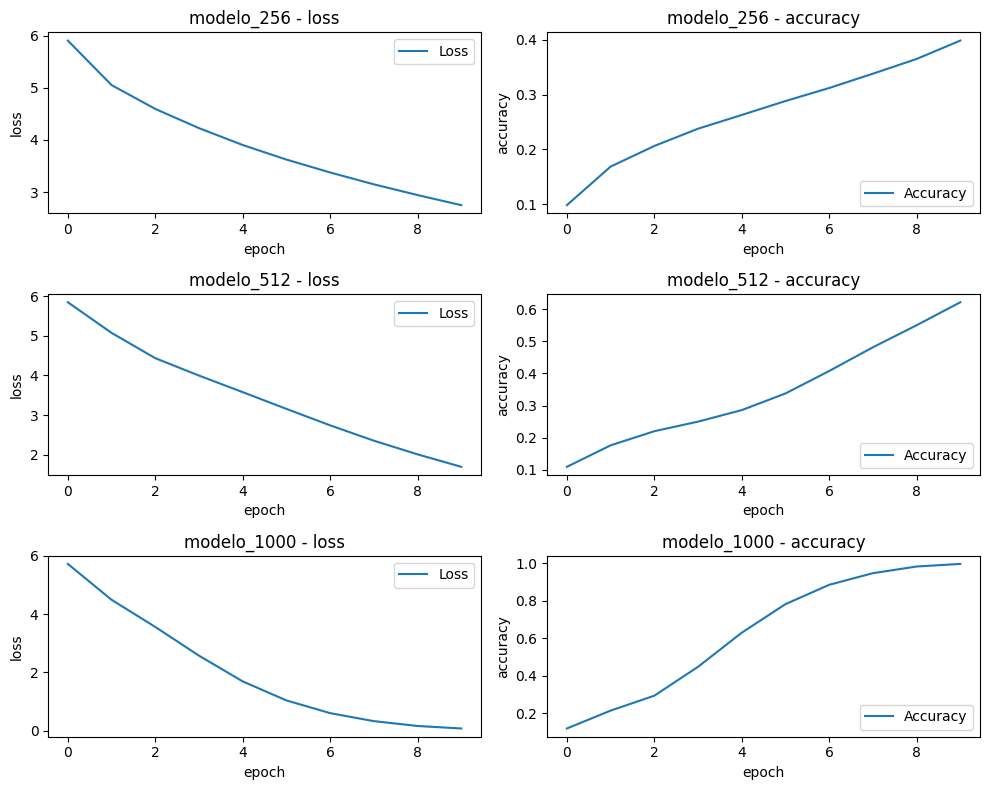

In [114]:
plot_history(history_list)

## Generación de texto

La generación de texto se basa en la función **get_index_from_prediction**, que obtiene un índice a partir de una predicción y un parámetro de temperatura

In [117]:
# Parámetros de generación de texto
generated_sequence_length = 50 # longitud de los textos generados
n_generated_texts = 15 # número de textos a generar

def generate_texts(n_generated_texts=10):

    print(f"Generamos {n_generated_texts} textos...")

    # carga del corpus
    indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

    # carga del modelo previamente grabado
    model = models.load_model(model_path)

    # Generamos tantos textos como indique el parámetro n_generated_texts
    for _ in range(n_generated_texts):

        # Escogemos un parámetro aleatorio "temperature" para la predicción
        temperature = random.uniform(0.0, 1.0)
        print("Temperatura:", temperature)

        # Obtenemos una muestra aleatoria a modo de secuencia semilla a partir de la cual se generarán textos
        random_index = random.randint(0, len(indices) - (generated_sequence_length))
        input_sequence = indices[random_index:random_index + sequence_length]

        # Convertimos la secuencia de índices de entrada en una frase
        #print("input_sequence:", input_sequence)
        text = decode_indices(input_sequence, vocabulary)
        print("Texto entrada: ", text)

        # Generamos la secuenca de salida repitiendo la predicción
        generated_sequence = []
        while len(generated_sequence) < generated_sequence_length:
            prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose = 0)
            predicted_index = get_index_from_prediction(prediction[0], temperature)
            generated_sequence.append(predicted_index)
            input_sequence = input_sequence[1:]
            #print("input_sequence:", input_sequence)
            input_sequence.append(predicted_index)

        # Convertimos la secuencia de índices generada en una frase
        #print("generated_sequence:", generated_sequence)
        text = decode_indices(generated_sequence, vocabulary)
        print("Texto generado: ", text)
        print("")


def get_index_from_prediction(prediction, temperature=0.0):

    # Temperatura cero - usamos argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Temperatura distinta de cero - aplicamos cierta aleatoriedad
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate_texts(n_generated_texts)

Generamos 15 textos...


Temperatura: 0.714597409960669
Texto entrada:  that , you know , ” Alice gently remarked ; “ they ’ d have been ill. ” “ So they were , ” said the Dormouse ; “ _very_
Texto generado:  ill. ” Alice tried to fancy to herself what such an extraordinary way of tears “ Come , I ’ m sure to ask me a story ! ” “ I _have_ you more , ” said Alice ; “ it ’ s laid her own more as an of

Temperatura: 0.6560870880418379
Texto entrada:  don ’ t bother _me_ , ” said the Duchess ; “ I never could abide figures ! ” And with that she began nursing her child again , singing
Texto generado:  a sort of lullaby to it , and all just at another moment , it was some tears to keep her ; then , as they all crowded at the Duchess , she was this much to the back of her sister , but at the time she went on

Temperatura: 0.13745969730772256
Texto entrada:  that she was now the right size for going through the little door into that lovely garden . First , however , she waited for a few minutes to see
Texto generado: 

## Conclusiones

### Comparativa entre los tamaños de la capa LSTM
Pudimos experimentar con diferentes tamaños en la capa LSTM identificando el efecto que tiene cada uno de los valores, a saber se utilizaron 3 tamaños diferentes: 256, 512 y 1000. Los primeros dos son valores encontrados en diferentes lecturas sobre donde se los identifica como "comunes" durante etapas de experimentación, mientras que el último es el tamaño propuesto en la actividad.

Aumentar el tamaño conlleva un aumento considerable en el tiempo de entrenamiento del modelo, vimos que utilizar una capa LSTM con 256 nodos ocultos implica un tiempo de alrededor de **5 segundos por epoch**, mientras que el tiempo medio con 512 y 1000 nodos ocultos fué de **8.2 y 18.6 segundos por epoch** respectivamente.

Asimismo, notamos que al aumentar el tamaño del modelo tambien mejoran las métricas de evaluación del mismo. Como muestran las imagenes, los tres modelos convergen de diferente manera a medida que transcurren las iteraciones de entrenamiento. Para modelo de 256 nodos encontramos unos valores de accuracy de **0.398** y loss de **2.75** al concluir el décimo epoch de entrenamiento. Para el modelo de 512 nodos los valores son consitentemente mejores, tanto accuracy como loss mejoraron en sus medidas, obteniendo valores de **0.62 y 1.7** respectivamente al finalizar el entrenamiento. Los resultados para el último modelo son incluso mejores, marcando una accuracy de **0.99** y un valor de loss de **0.071**

### Comentarios sobre los resultados
Se realizaron pequeñas modificaciones al código original provisto con la intención de mejorar la interpretabilidad del proceso generativo. Se puede notar que el modelo generador pudo extraer y reproducir el estilo de `Alice’s Adventures in Wonderland`. Si bien, los resultados obtenidos no son completamente comprensibles y se percibe falta de coherencia en algunos casos, los textos generados son remarcables. El modelo es capaz de emular el estilo "conversacional" en el que la historia está redactada. Aunque la generación no es perfecta se puede apreciar cierto hilo de similitud entre la frase inicial utilizada y el resultado generado. Podemos ver, en algunos ejemplos donde el modelo reutiliza algunas de las palabras que sirvieron de input, generalmente parece reutilizar nombres propios presentes en la entrada para generar los textos a su salida. Es tambien interesante remarcar el uso de los simbolos de puntuación por parte del modelo, por ejemplo la utilización correcta de las comillas dobles (`"`), indicando citas de los personajes de la obra, por lo general estas acompañadas de estructuras correctas ("said Alice", "the Gryphon replied").
